## Import libraries

In [2]:
#Imports
import os

# Libraries for general purpose
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Text cleaning
import re
import string
import emoji
import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords

# Data preprocessing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from langdetect import detect, LangDetectException
import contractions
from nltk.tokenize import word_tokenize

# Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

# PyTorch LSTM
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Tokenization for LSTM
from collections import Counter
from gensim.models import Word2Vec

# Transformers library for BERT
import transformers
from transformers import BertModel
from transformers import BertTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import classification_report, confusion_matrix

import time
import nltk
import demoji
nltk.download('punkt')
nltk.download('wordnet')
# Set seed for reproducibility
import random

c:\Users\romul\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\romul\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\romul\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Data Import

In [3]:
nome_do_arquivo = "cyberbullying_tweets.csv"
# Read the file CSV
df = pd.read_csv(nome_do_arquivo)

#Performing some initial configuration for data visualization and word processing
seed_value = 2042
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)

# Set style for plots
sns.set_style("whitegrid")
sns.despine()
plt.style.use("seaborn-v0_8-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)
nltk.download('stopwords')
# Define stop words for text cleaning
stop_words = set(stopwords.words('english'))

# Initialize lemmatizer for text cleaning
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\romul\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<Figure size 640x480 with 0 Axes>

In [4]:
#Rename Colun
df = df.rename(columns={'tweet_text': 'text', 'cyberbullying_type': 'sentiment'})
#Remove Duplicates 
df = df[~df.duplicated()]

# Tweets text deep cleaning

Next, we will define custom functions to clean the texts of the tweets.

In [5]:
# Clean emojis from text

def strip_emoji(text):
    return demoji.replace(text, '')
# Remove punctuations, stopwords, links, mentions and new line characters
def strip_all_entities(text):
    text = re.sub(r'\r|\n', ' ', text.lower())  # Replace newline and carriage return with space, and convert to lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)  # Remove links and mentions
    text = re.sub(r'[^\x00-\x7f]', '', text)  # Remove non-ASCII characters
    banned_list = string.punctuation
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

# Clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
def clean_hashtags(tweet):
    # Remove hashtags at the end of the sentence
    new_tweet = re.sub(r'(\s+#[\w-]+)+\s*$', '', tweet).strip()

    # Remove the # symbol from hashtags in the middle of the sentence
    new_tweet = re.sub(r'#([\w-]+)', r'\1', new_tweet).strip()

    return new_tweet

# Filter special characters such as & and $ present in some words
def filter_chars(text):
    return ' '.join('' if ('$' in word) or ('&' in word) else word for word in text.split())

# Remove multiple spaces
def remove_mult_spaces(text):
    return re.sub(r"\s\s+", " ", text)

# Function to check if the text is in English, and return an empty string if it's not
def filter_non_english(text):
    try:
        lang = detect(text)
    except LangDetectException:
        lang = "unknown"
    return text if lang == "en" else ""

# Expand contractions
def expand_contractions(text):
    return contractions.fix(text)

# Remove numbers
def remove_numbers(text):
    return re.sub(r'\d+', '', text)

# Lemmatize words
def lemmatize(text):
    words = word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

# Remove short words
def remove_short_words(text, min_len=2):
    words = text.split()
    long_words = [word for word in words if len(word) >= min_len]
    return ' '.join(long_words)

# Replace elongated words with their base form
def replace_elongated_words(text):
    regex_pattern = r'\b(\w+)((\w)\3{2,})(\w*)\b'
    return re.sub(regex_pattern, r'\1\3\4', text)

# Remove repeated punctuation
def remove_repeated_punctuation(text):
    return re.sub(r'[\?\.\!]+(?=[\?\.\!])', '', text)

# Remove extra whitespace
def remove_extra_whitespace(text):
    return ' '.join(text.split())

def remove_url_shorteners(text):
    return re.sub(r'(?:http[s]?://)?(?:www\.)?(?:bit\.ly|goo\.gl|t\.co|tinyurl\.com|tr\.im|is\.gd|cli\.gs|u\.nu|url\.ie|tiny\.cc|alturl\.com|ow\.ly|bit\.do|adoro\.to)\S+', '', text)

# Remove spaces at the beginning and end of the tweet
def remove_spaces_tweets(tweet):
    return tweet.strip()

# Remove short tweets
def remove_short_tweets(tweet, min_words=3):
    words = tweet.split()
    return tweet if len(words) >= min_words else ""

# Function to call all the cleaning functions in the correct order
def clean_tweet(tweet):
    tweet = strip_emoji(tweet)
    tweet = expand_contractions(tweet)
    tweet = filter_non_english(tweet)
    tweet = strip_all_entities(tweet)
    tweet = clean_hashtags(tweet)
    tweet = filter_chars(tweet)
    tweet = remove_mult_spaces(tweet)
    tweet = remove_numbers(tweet)
    tweet = lemmatize(tweet)
    tweet = remove_short_words(tweet)
    tweet = replace_elongated_words(tweet)
    tweet = remove_repeated_punctuation(tweet)
    tweet = remove_extra_whitespace(tweet)
    tweet = remove_url_shorteners(tweet)
    tweet = remove_spaces_tweets(tweet)
    tweet = remove_short_tweets(tweet)
    tweet = ' '.join(tweet.split())  # Remove multiple spaces between words
    return tweet
    #Limpando Dados



In [6]:
#Limpando Dados
df['text_clean'] = [clean_tweet(tweet) for tweet in df['text']]

In [7]:
df.head()
df.drop_duplicates("text_clean", inplace=True)
df.sentiment.value_counts()

sentiment
religion               7919
age                    7811
ethnicity              7411
gender                 7280
not_cyberbullying      6070
other_cyberbullying    4907
Name: count, dtype: int64

In [8]:
# Mapping the ratings to the desired categories
mapping = {
    'religion': 'Bullying',
    'age': 'Bullying',
    'ethnicity': 'Bullying',
    'gender': 'Bullying',
    'not_cyberbullying': 'Não Bullying',
    'other_cyberbullying': 'Bullying'
}
sentiments = ["Bullying","Não Bullying"]

# Applying mapping to the 'sentiment' column
df['sentiment'] = df['sentiment'].map(mapping)

# Checking counts after transformation
df['sentiment'].value_counts()

sentiment
Bullying        35328
Não Bullying     6070
Name: count, dtype: int64

In [9]:
print(f'There are around {int(df["text_clean"].duplicated().sum())} duplicated tweets, we will remove them.')

There are around 0 duplicated tweets, we will remove them.


In [10]:
df.drop_duplicates("text_clean", inplace=True)

# Tweets length analysis

Now we will define a new dataframe column containing the length of the cleaned tweets in terms of number of words.

In [11]:
df['text_len'] = [len(text.split()) for text in df.text_clean]

C:\Users\romul\AppData\Local\Temp\ipykernel_25784\631618343.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='text_len', data=df[df['text_len']<10], palette='mako')


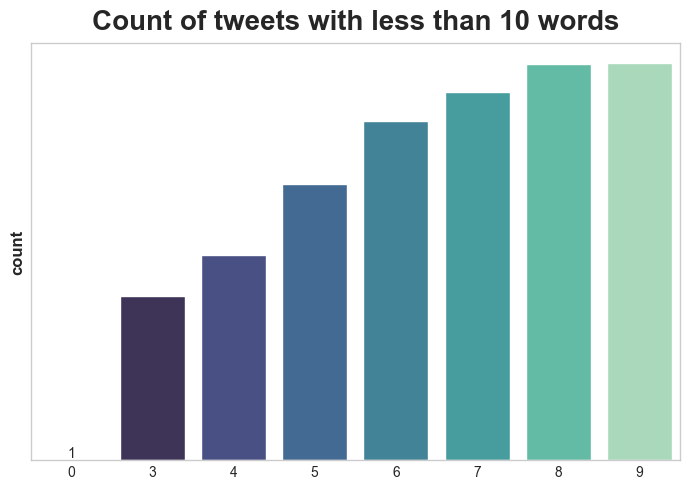

In [12]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=df[df['text_len']<10], palette='mako')
plt.title('Count of tweets with less than 10 words', fontsize=20)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

In [13]:
df.sort_values(by=['text_len'], ascending=False)

,text,sentiment,text_clean,text_len
29205,is feminazi an actual word with a denot…\r\n@N...,Bullying,feminazi actual word denot job mean protecting...,372
24516,@NICKIMINAJ: #WutKinda\r\nAt this rate the MKR...,Bullying,wutkinda rate mkr final december mkr haha true...,335
30752,I don't retreat.\r\nyessssssss http://t.co/Td9...,Bullying,retreat yes uh make grownup boruto look lit ba...,233
44035,You so black and white trying to live like a n...,Bullying,black white trying live like nigger pahahahaha...,173
45165,"@hermdiggz: “@tayyoung_: FUCK OBAMA, dumb ass ...",Bullying,fuck obama dumb as nigger bitch ltthis whore s...,151
...,...,...,...,...
31349,@a_man_in_black good luck tho.,Bullying,good luck though,3
5660,@Willie_B904 then u gonna go broke,Não Bullying,going go broke,3
1468,@beardyblue it's a long winding story. :P,Não Bullying,long winding story,3
25756,I'm no princess that needs a knight,Bullying,princess need knight,3


C:\Users\romul\AppData\Local\Temp\ipykernel_25784\2060477503.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='text_len', data=df[(df['text_len']<=1000) & (df['text_len']>10)], palette='Blues_r')


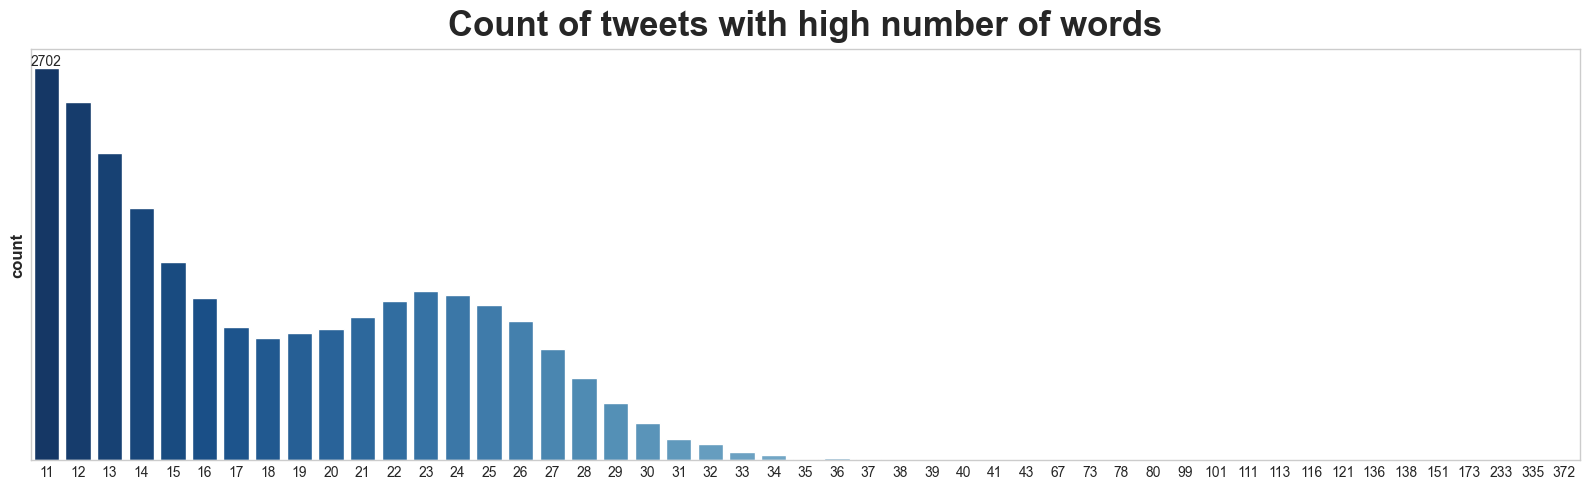

In [14]:
plt.figure(figsize=(16,5))
ax = sns.countplot(x='text_len', data=df[(df['text_len']<=1000) & (df['text_len']>10)], palette='Blues_r')
plt.title('Count of tweets with high number of words', fontsize=25)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

We also will remove tweets that are too long (with more than 100 words).

In [15]:
df = df[df['text_len'] < df['text_len'].quantile(0.995)]

Then we also get the length of the longest tweet since it will be useful later.

In [16]:
max_len = np.max(df['text_len'])
max_len

31

In [17]:
df.sort_values(by=["text_len"], ascending=False)

,text,sentiment,text_clean,text_len
38934,Someone needs to tell social media users how h...,Bullying,someone need tell social medium user high scho...,31
18620,There has never been a historical Assamese Mus...,Bullying,never historical assamese muslim society think...,31
20828,#ISIS #OsamabinLaden #Hizbul &amp;all #terrori...,Bullying,isi osamabinladen hizbul ampall terrorist read...,31
20826,"Hey Idiot, Already muslim got land of their cl...",Bullying,hey idiot already muslim got land claim porkis...,31
36873,I really let myself be bullied into straighten...,Bullying,really let bullied straightening hair begging ...,31
...,...,...,...,...
8010,@EqualityMen The motive doesn't lessen the out...,Bullying,motive lessen outcome,3
8037,Kat is a sociopath #mkr,Bullying,kat sociopath mkr,3
24448,"RT @PlayHearthstone: Roses are red,",Bullying,rt rose red,3
25584,@AYPrivateEye @Lexi @PaigeSpiranac Stop trolli...,Bullying,stop trolling idiot,3


## Sentiment column encoding

The target column will be encoded by ordinal encoding

In [18]:
df['sentiment'] = df['sentiment'].replace({'Bullying':0,'Não Bullying':1})

## Train - Test split

Now we need to split the dataset into a train and test sets.

In [19]:
X = df['text_clean']
y = df['sentiment']
print(y)

0        1
1        1
2        1
3        1
4        1
        ..
47687    0
47688    0
47689    0
47690    0
47691    0
Name: sentiment, Length: 41149, dtype: int64


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed_value)

## Train - Validation split

Moreover, we will further split the training set to extract a validation set, which will be used to monior the accuracy and loss to avoid overfitting during the model training.

In [21]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=seed_value)


In [22]:
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[    0, 22452],
       [    1,  3883]], dtype=int64)

The classes are unbalanced, so it could be a good idea to oversample the training set such that all classes have the same count as the most populated one.

# Oversampling of training set

In [23]:
ros = RandomOverSampler()
X_train, y_train = ros.fit_resample(np.array(X_train).reshape(-1, 1), np.array(y_train).reshape(-1, 1));
train_os = pd.DataFrame(list(zip([x[0] for x in X_train], y_train)), columns = ['text_clean', 'sentiment']);


In [24]:
X_train = train_os['text_clean'].values
y_train = train_os['sentiment'].values

In [25]:
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[    0, 22452],
       [    1, 22452]], dtype=int64)

# Naive Bayes baseline model

The first algorithm we will implement is Naive Bayes, which will be used as a simple baseline model. In order to use this algorithm, we need first need to preprocess the text data. <br>
First, we will create a bag of words using CountVectorizer.

In [26]:
# Pipeline com TfidfVectorizer e MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
text_clf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

Then we apply TF-IFD transformation to associate weigths to the different words based on their frequency (rarer words will be given more importance).

In [27]:
# Define Params 
parameters = {
    'tfidf__max_features': [5000, 10000, None],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'clf__alpha': [0.1, 0.5, 1.0]
}

Finally we can instantiate the Naive Bayes model.

In [28]:
from sklearn.model_selection import GridSearchCV
# Creating a objetc GridSearchCV
grid_search = GridSearchCV(text_clf, parameters, cv=5, n_jobs=-1)

# Training the model using  GridSearchCV
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('clf', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'clf__alpha': [0.1, 0.5, 1.0],
                         'tfidf__max_features': [5000, 10000, None],
                         'tfidf__ngram_range': [(1, 1), (1, 2)]})

In [29]:
# Print the best params
print("Melhores Parâmetros:")
print(grid_search.best_params_)

Melhores Parâmetros:
{'clf__alpha': 0.1, 'tfidf__max_features': None, 'tfidf__ngram_range': (1, 2)}


In [30]:

# Accessing the best trained model
best_model = grid_search.best_estimator_

# Evaluating the model on test data
y_pred = best_model.predict(X_test)

In [31]:
# Generating and printing the classification report
print("Relatório de Classificação:\n", classification_report(y_test, y_pred))

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.92      0.94      0.93      7017
           1       0.59      0.54      0.56      1213

    accuracy                           0.88      8230
   macro avg       0.76      0.74      0.75      8230
weighted avg       0.87      0.88      0.88      8230



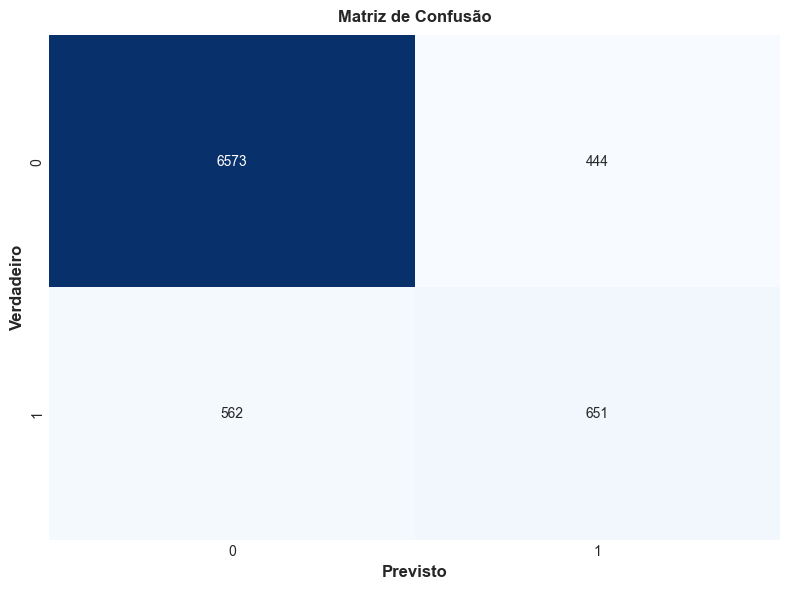

In [32]:
# Generating the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Displaying the confusion matrix with seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Previsto')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão')
plt.show()

# PyTorch LSTM RNN w/ Attention

In this section, we will define a custom Unidirectional and Bidirectional LSTM using PyTorch in order to perform the Sentiment Analysis on the tweets.

## Data preprocessing for LSTM

Similarly to what we did with Naive Bayes, we need to preprocess the data: in particular we will tokenize the sentences with a custom defined function. <br>
The sentences will be converted to lists of number with padding to the max number of words in a sentence.

In [33]:
def Tokenize(column, seq_len):
    ##Create vocabulary of words from column
    corpus = [word for text in column for word in text.split()]
    count_words = Counter(corpus)
    sorted_words = count_words.most_common()
    vocab_to_int = {w:i+1 for i, (w,c) in enumerate(sorted_words)}

    ##Tokenize the columns text using the vocabulary
    text_int = []
    for text in column:
        r = [vocab_to_int[word] for word in text.split()]
        text_int.append(r)
    ##Add padding to tokens
    features = np.zeros((len(text_int), seq_len), dtype = int)
    for i, review in enumerate(text_int):
        if len(review) <= seq_len:
            zeros = list(np.zeros(seq_len - len(review)))
            new = zeros + review
        else:
            new = review[: seq_len]
        features[i, :] = np.array(new)

    return sorted_words, features

In [34]:
vocabulary, tokenized_column = Tokenize(df["text_clean"], max_len)

We can check how each tweet has been tokenized with an example:

In [35]:
df["text_clean"].iloc[0]

'word katandandre food crapilicious mkr'

This sentence is transformed to the vector:

In [36]:
tokenized_column[10]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     9,  8152, 16488])

Moreover we can also check the TOP 20 most common words by extracting them from the vocabulary python dictionary we created with the tokenizer.

In [37]:
keys = []
values = []
for key, value in vocabulary[:20]:
    keys.append(key)
    values.append(value)
print(values)

[8893, 5637, 5453, 5391, 5266, 5055, 5048, 4937, 4889, 4787, 4681, 4548, 4060, 3985, 3849, 3570, 3386, 3097, 2930, 2891]


C:\Users\romul\AppData\Local\Temp\ipykernel_25784\2081876966.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=keys, y=values, palette='mako')


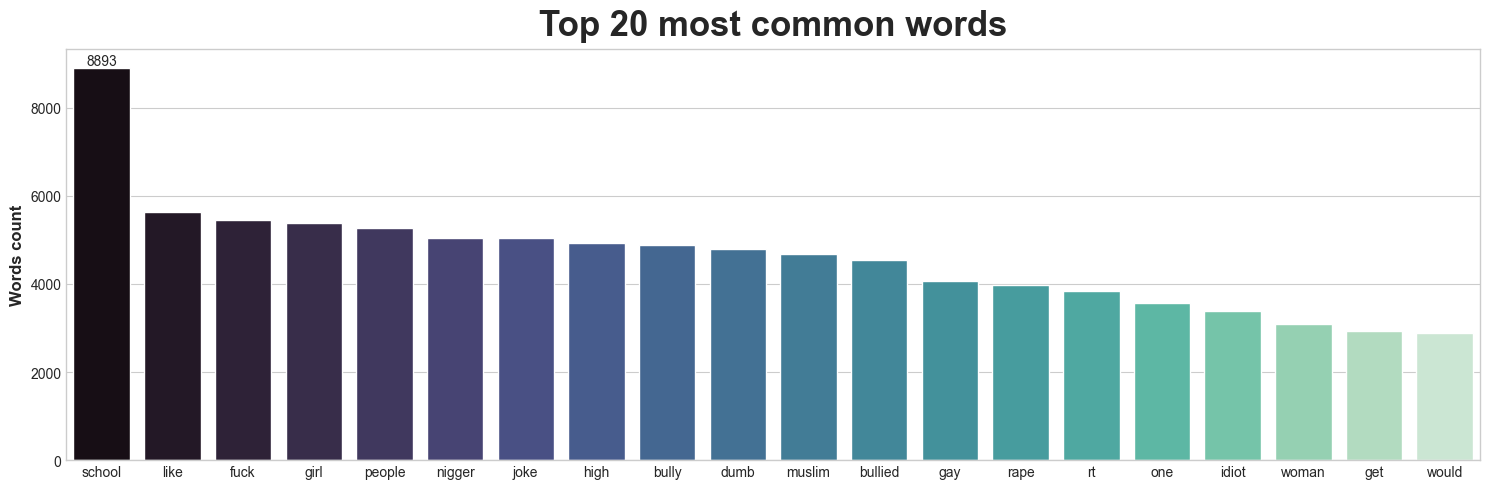

In [38]:
plt.figure(figsize=(15, 5))
ax = sns.barplot(x=keys, y=values, palette='mako')
plt.title('Top 20 most common words', size=25)
ax.bar_label(ax.containers[0])
plt.ylabel("Words count")
plt.show()

*Next we will implement a more complex algorithm to perform the classification, aiming to achieve higher accurcy than the baseline Naive Bayes model.*

# Word Embedding by Word2Vec

Next, we will create a word embedding matrix using the original text tweets and the pre trained model Word2vec.<br>
First, we create a list of words from the X_train vector created before.

In [39]:
Word2vec_train_data = list(map(lambda x: x.split(), X_train))

In [40]:
EMBEDDING_DIM = 200


In [41]:
word2vec_model = Word2Vec(Word2vec_train_data, vector_size=EMBEDDING_DIM)

We set a dimension of the embedding words, which can be seen as the number of featurs of each transformed word.

Then we can instaniate the Word2Vec model by passing the training words and chosen embedding dimension to the imported Word2vec object.

Before defining the embedding matrix, we also need to choose the max number of words. We will extract the number of words from the vocabulary python dictionary we created before.

In [42]:
print(f"Vocabulary size: {len(vocabulary) + 1}")

Vocabulary size: 39779


In [43]:
VOCAB_SIZE = len(vocabulary) + 1 #+1 for the padding

Finally we can define the embedding matrix.

In [44]:
# Define an empty embedding matrix of shape (VOCAB_SIZE, EMBEDDING_DIM)
embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))

# Fill the embedding matrix with pre-trained values from word2vec
for word, token in vocabulary:
    # Check if the word is present in the word2vec model's vocabulary
    if word in word2vec_model.wv.key_to_index:
        # If the word is present, retrieve its embedding vector and add it to the embedding matrix
        embedding_vector = word2vec_model.wv[word]
        embedding_matrix[token] = embedding_vector

# Print the shape of the embedding matrix
print("Embedding Matrix Shape:", embedding_matrix.shape)

Embedding Matrix Shape: (39779, 200)


## Train - Validation - Test split

Now we will use the tokenized sentences to create a training, validation and test datasets.

In [45]:
X = tokenized_column
y = df['sentiment'].values

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed_value)

In [47]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=seed_value)

We can check the balance of the target classes:

In [48]:
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[    0, 22452],
       [    1,  3883]], dtype=int64)

And then apply random oversampling on the training set.

In [49]:
ros = RandomOverSampler()
X_train_os, y_train_os = ros.fit_resample(np.array(X_train),np.array(y_train));

In [50]:
print(X_train_os)

[[    0     0     0 ...     6  1068 38630]
 [    0     0     0 ...    36  4481   536]
 [    0     0     0 ...    10    22     6]
 ...
 [    0     0     0 ...    69  4559    26]
 [    0     0     0 ...     2  3811   229]
 [    0     0     0 ...  2173  6012   197]]


In [51]:
(unique, counts) = np.unique(y_train_os, return_counts=True)
np.asarray((unique, counts)).T

array([[    0, 22452],
       [    1, 22452]], dtype=int64)

## PyTorch datasets and dataloaders

The three sets will be transformed to tensor datasets and dataloaders so we can extract the data in batches for the LSTM training, validation and testing.

In [52]:
train_data = TensorDataset(torch.from_numpy(X_train_os), torch.from_numpy(y_train_os))
test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
valid_data = TensorDataset(torch.from_numpy(X_valid), torch.from_numpy(y_valid))

In [53]:
BATCH_SIZE = 32

In [54]:
train_loader = DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)
valid_loader = DataLoader(valid_data, shuffle=False, batch_size=BATCH_SIZE, drop_last=True)
test_loader = DataLoader(test_data, shuffle=False, batch_size=BATCH_SIZE, drop_last=True)

# PyTorch LSTM modeling with Attention Layer

In this chapter we implement two Python classes: Attention and LSTM_Sentiment_Classifier.
Next, we define our LSTM_Sentiment_Classifier class, which uses the Attention mechanism to make predictions. This class includes an LSTM network which takes embedded word representations as input and outputs hidden states. It also includes an attention layer, which uses these hidden states to compute attention weights and apply them to the encoder outputs to get a context vector. This context vector is passed through a fully connected layer followed by a log-softmax function to produce the final output probabilities.

This LSTM model with attention allows us to better handle the complexities of language understanding by giving more importance to the relevant parts of our text data. This enhances the model's ability to understand context and thereby, improves the performance of our Sentiment Analysis task.

In [55]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

class Attention(nn.Module):
    def __init__(self, hidden_dim, is_bidirectional):
        super(Attention, self).__init__()
        self.is_bidirectional = is_bidirectional
        self.attn = nn.Linear(hidden_dim * (4 if is_bidirectional else 2), hidden_dim * (2 if is_bidirectional else 1))
        self.v = nn.Linear(hidden_dim * (2 if is_bidirectional else 1), 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        seq_len = encoder_outputs.size(1)
        if self.is_bidirectional:
            hidden = torch.cat((hidden[-2], hidden[-1]), dim=-1)
        else:
            hidden = hidden[-1]
        hidden_repeated = hidden.unsqueeze(1).repeat(1, seq_len, 1)
        attn_weights = torch.tanh(self.attn(torch.cat((hidden_repeated, encoder_outputs), dim=2)))
        attn_weights = self.v(attn_weights).squeeze(2)
        return nn.functional.softmax(attn_weights, dim=1)

class LSTM_Sentiment_Classifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes, lstm_layers, dropout, is_bidirectional):
        super(LSTM_Sentiment_Classifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = lstm_layers
        self.is_bidirectional = is_bidirectional

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, lstm_layers, batch_first=True, bidirectional=is_bidirectional, dropout=dropout)
        self.attention = Attention(hidden_dim, is_bidirectional)
        self.fc = nn.Linear(hidden_dim * (2 if is_bidirectional else 1), num_classes)
        self.batch_norm = nn.BatchNorm1d(num_features=self.fc.out_features)
        self.softmax = nn.LogSoftmax(dim=1)
        self.dropout = nn.Dropout(dropout)

        self.optimizer = optim.Adam(self.parameters(), lr=0.001)
        self.scheduler = ReduceLROnPlateau(self.optimizer, 'min', patience=2, factor=0.5, verbose=True)

        # Adicione inicialização de pesos
        nn.init.xavier_uniform_(self.fc.weight)

    def forward(self, x, hidden):
        embedded = self.embedding(x)
        out, hidden = self.lstm(embedded, hidden)
        attn_weights = self.attention(hidden[0], out)
        context = attn_weights.unsqueeze(1).bmm(out).squeeze(1)

        out = self.fc(context)
        out = self.batch_norm(out)
        out = self.softmax(out)

        return out, hidden

    def init_hidden(self, batch_size):
        factor = 2 if self.is_bidirectional else 1
        h0 = torch.zeros(self.num_layers * factor, batch_size, self.hidden_dim).to(DEVICE)
        c0 = torch.zeros(self.num_layers * factor, batch_size, self.hidden_dim).to(DEVICE)
        return (h0, c0)




In [56]:
NUM_CLASSES = 5 #We are dealing with a multiclass classification of 5 classes
HIDDEN_DIM = 100 #number of neurons of the internal state (internal neural network in the LSTM)
LSTM_LAYERS = 1 #Number of stacked LSTM layers

IS_BIDIRECTIONAL = False # Set this to False for unidirectional LSTM, and True for bidirectional LSTM

LR = 4e-4 
DROPOUT = 0.5 
EPOCHS = 10 

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

model = LSTM_Sentiment_Classifier(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, NUM_CLASSES, LSTM_LAYERS, DROPOUT, IS_BIDIRECTIONAL)

model = model.to(DEVICE)

# Initialize the embedding layer with the previously defined embedding matrix
model.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
# Allow the embedding matrix to be fine-tuned to better adapt to our dataset and get higher accuracy
model.embedding.weight.requires_grad = True

# Set up the criterion (loss function)
criterion = nn.NLLLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay = 5e-6)

print(model)

c:\Users\romul\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


LSTM_Sentiment_Classifier(
  (embedding): Embedding(39779, 200)
  (lstm): LSTM(200, 100, batch_first=True, dropout=0.5)
  (attention): Attention(
    (attn): Linear(in_features=200, out_features=100, bias=True)
    (v): Linear(in_features=100, out_features=1, bias=False)
  )
  (fc): Linear(in_features=100, out_features=5, bias=True)
  (batch_norm): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (softmax): LogSoftmax(dim=1)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [57]:
print(len(valid_loader))
print(len(train_loader))

205
1403


# LSTM Training loop

Now we will define a custom training loop, where we include an early stopping functionality, and save only the best models in terms of validation accuracy.

In [58]:
total_step = len(train_loader)
total_step_val = len(valid_loader)

early_stopping_patience = 4
early_stopping_counter = 0

valid_acc_max = 0 # Initialize best accuracy top 0
# inicializar o scheduler de taxa de aprendizado
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5, verbose=True)

for e in range(EPOCHS):

    #lists to host the train and validation losses of every batch for each epoch
    train_loss, valid_loss  = [], []
    #lists to host the train and validation accuracy of every batch for each epoch
    train_acc, valid_acc  = [], []

    #lists to host the train and validation predictions of every batch for each epoch
    y_train_list, y_val_list = [], []

    #initalize number of total and correctly classified texts during training and validation
    correct, correct_val = 0, 0
    total, total_val = 0, 0
    running_loss, running_loss_val = 0, 0


   ####TRAINING LOOP####
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        h = model.init_hidden(labels.size(0))
        model.zero_grad()
        output, h = model(inputs, h)
        loss = criterion(output, labels)
        loss.backward()
        running_loss += loss.item()
        optimizer.step()
        y_pred_train = torch.argmax(output, dim=1)
        y_train_list.extend(y_pred_train.squeeze().tolist())
        correct += torch.sum(y_pred_train == labels).item()
        total += labels.size(0)

    train_loss.append(running_loss / total_step)
    train_acc.append(100 * correct / total)

    ####VALIDATION LOOP####
    with torch.no_grad():
        model.eval()
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            val_h = model.init_hidden(labels.size(0))
            output, val_h = model(inputs, val_h)
            val_loss = criterion(output, labels)
            running_loss_val += val_loss.item()
            y_pred_val = torch.argmax(output, dim=1)
            y_val_list.extend(y_pred_val.squeeze().tolist())
            correct_val += torch.sum(y_pred_val == labels).item()
            total_val += labels.size(0)

        valid_loss.append(running_loss_val / total_step_val)
        valid_acc.append(100 * correct_val / total_val)

    # Save model if validation accuracy increases
    if np.mean(valid_acc) >= valid_acc_max:
        torch.save(model.state_dict(), './state_dict.pt')
        print(f'Epoch {e+1}:Validation accuracy increased ({valid_acc_max:.6f} --> {np.mean(valid_acc):.6f}).  Saving model ...')
        valid_acc_max = np.mean(valid_acc)
        early_stopping_counter = 0  # reset counter if validation accuracy increases
    else:
        print(f'Epoch {e+1}:Validation accuracy did not increase')
        early_stopping_counter += 1  # increase counter if validation accuracy does not increase

    if early_stopping_counter > early_stopping_patience:
        print('Early stopped at epoch :', e+1)
        break

    print(f'\tTrain_loss : {np.mean(train_loss):.4f} Val_loss : {np.mean(valid_loss):.4f}')
    print(f'\tTrain_acc : {np.mean(train_acc):.3f}% Val_acc : {np.mean(valid_acc):.3f}%')

    # Adicione esta linha para ajustar dinamicamente a taxa de aprendizado
    scheduler.step(np.mean(valid_loss))

Epoch 1:Validation accuracy increased (0.000000 --> 85.548780).  Saving model ...
	Train_loss : 0.7635 Val_loss : 0.5847
	Train_acc : 85.823% Val_acc : 85.549%
Epoch 2:Validation accuracy increased (85.548780 --> 87.164634).  Saving model ...
	Train_loss : 0.3123 Val_loss : 0.4590
	Train_acc : 95.699% Val_acc : 87.165%
Epoch 3:Validation accuracy did not increase
	Train_loss : 0.1548 Val_loss : 0.5025
	Train_acc : 98.020% Val_acc : 86.631%
Epoch 4:Validation accuracy did not increase
	Train_loss : 0.0883 Val_loss : 0.5396
	Train_acc : 98.871% Val_acc : 86.357%
Epoch 5:Validation accuracy did not increase
	Train_loss : 0.0598 Val_loss : 0.5745
	Train_acc : 99.109% Val_acc : 86.098%
Epoch 00005: reducing learning rate of group 0 to 2.0000e-04.
Epoch 6:Validation accuracy did not increase
	Train_loss : 0.0390 Val_loss : 0.6286
	Train_acc : 99.488% Val_acc : 86.052%
Epoch 7:Validation accuracy did not increase
Early stopped at epoch : 7


In [59]:
# Loading the best model
model.load_state_dict(torch.load('./state_dict.pt'))

<All keys matched successfully>

# LSTM Testing

In [60]:
def evaluate_model(model, test_loader):
    model.eval()
    y_pred_list = []
    y_test_list = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            test_h = model.init_hidden(labels.size(0))

            output, val_h = model(inputs, test_h)
            y_pred_test = torch.argmax(output, dim=1)
            y_pred_list.extend(y_pred_test.squeeze().tolist())
            y_test_list.extend(labels.squeeze().tolist())

    return y_pred_list, y_test_list

y_pred_list, y_test_list = evaluate_model(model, test_loader)

In [61]:
print('Classification Report for Bi-LSTM :\n', classification_report(y_test_list, y_pred_list, target_names=sentiments))

Classification Report for Bi-LSTM :
               precision    recall  f1-score   support

    Bullying       0.91      0.95      0.93      7011
Não Bullying       0.62      0.48      0.54      1213

    accuracy                           0.88      8224
   macro avg       0.77      0.71      0.74      8224
weighted avg       0.87      0.88      0.87      8224



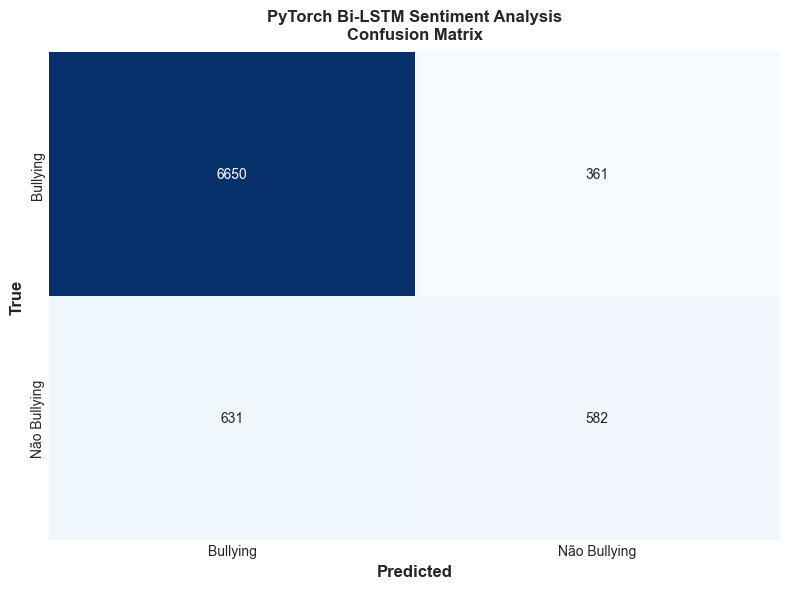

In [67]:
def conf_matrix(y_true, y_pred, title, labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


conf_matrix(y_test_list, y_pred_list, 'PyTorch Bi-LSTM Sentiment Analysis\nConfusion Matrix', sentiments)

# GRU model


In [78]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [86]:
# Tokenização
# Converta a matriz NumPy X_train em uma lista de strings
X_train_texts = [' '.join(map(str, x)) for x in X_train]
X_test_texts = [' '.join(map(str, x)) for x in X_test]

# Tokenização
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_texts)
X_train_seq = tokenizer.texts_to_sequences(X_train_texts)
X_test_seq = tokenizer.texts_to_sequences(X_test_texts)


In [87]:
# Padding to have fixed length sequences
max_len = max(max(len(seq) for seq in X_train_seq), max(len(seq) for seq in X_test_seq))
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

In [88]:
# Converting text lists to NumPy arrays
y_train = np.array(y_train)
y_test = np.array(y_test)

In [89]:
from tensorflow.keras.layers import Input, Embedding, GRU, Bidirectional, Dense, Dropout, Attention, GlobalAveragePooling1D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
# Construction of the Bidirectional GRU model
# Building the model with attention layer
input_layer = Input(shape=(max_len,))
embedding_layer = Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=max_len)(input_layer)
gru_layer = Bidirectional(GRU(64, return_sequences=True))(embedding_layer)
attention = Attention()([gru_layer, gru_layer])
context = GlobalAveragePooling1D()(attention)
concatenated = Concatenate()([context, GlobalAveragePooling1D()(gru_layer)])
dropout_layer = Dropout(0.5)(concatenated)
dense_layer = Dense(32, activation='relu')(dropout_layer)
dropout_layer2 = Dropout(0.5)(dense_layer)
output_layer = Dense(1, activation='sigmoid')(dropout_layer2)

model = Model(inputs=input_layer, outputs=output_layer)

In [90]:
# Compiling the model with an Adam optimizer and adaptive learning rate
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [91]:
# Model training
model.fit(X_train_pad, y_train, epochs=5, batch_size=32, validation_split=0.1)


Epoch 1/5


741/741 [==============================] - 29s 34ms/step - loss: 0.2757 - accuracy: 0.8684 - val_loss: 0.2405 - val_accuracy: 0.8800
Epoch 2/5
741/741 [==============================] - 25s 34ms/step - loss: 0.1874 - accuracy: 0.9132 - val_loss: 0.2633 - val_accuracy: 0.8736
Epoch 3/5
741/741 [==============================] - 25s 33ms/step - loss: 0.1279 - accuracy: 0.9457 - val_loss: 0.3604 - val_accuracy: 0.8717
Epoch 4/5
741/741 [==============================] - 25s 34ms/step - loss: 0.0806 - accuracy: 0.9662 - val_loss: 0.5174 - val_accuracy: 0.8751
Epoch 5/5
741/741 [==============================] - 25s 33ms/step - loss: 0.0533 - accuracy: 0.9789 - val_loss: 0.5779 - val_accuracy: 0.8740


In [92]:
# Evaluating the model on test data
y_pred_prob = model.predict(X_test_pad)

# Converting probabilities to binary classes
y_pred = (y_pred_prob > 0.5).astype(int)
print("Relatório de Classificação:\n", classification_report(y_test, y_pred))

258/258 [==============================] - 2s 7ms/step
Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.91      0.95      0.93      7017
           1       0.62      0.47      0.53      1213

    accuracy                           0.88      8230
   macro avg       0.76      0.71      0.73      8230
weighted avg       0.87      0.88      0.87      8230



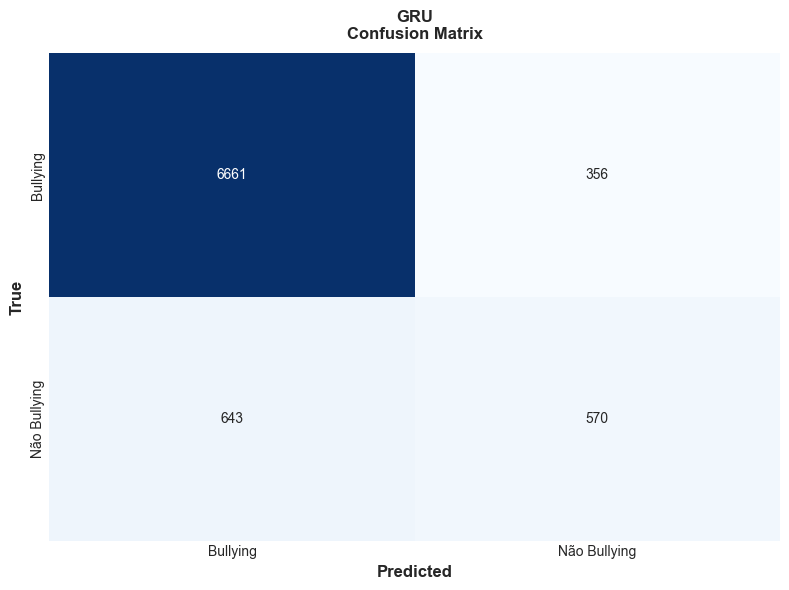

In [94]:
conf_matrix(y_test, y_pred, 'GRU\nConfusion Matrix', sentiments)